In [1]:
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import requests
import requests_cache
import matplotlib.pyplot as plt

# Cache HTTP requests to be polite and faster across runs
requests_cache.install_cache('cache_low_vol', backend='sqlite')
api_token = os.environ.get('EODHD_API_TOKEN')

import warnings
warnings.filterwarnings("ignore")

START_DATE = '2015-01-01'
UNIVERSE_INDEX = 'GSPC.INDX'  # EODHD index code for S&P 500
N_VOL = 10
ROLLING_WINDOW = 22  # ~1 month trading days

In [2]:
url = 'https://eodhd.com/api/mp/unicornbay/spglobal/comp/{}'.format(UNIVERSE_INDEX)
r = requests.get(url, params={'api_token': api_token, 'fmt': 'json'})
data = r.json()
df_symbols = pd.DataFrame(data['HistoricalTickerComponents']).T.reset_index()
df_symbols

,index,Code,Name,StartDate,EndDate,IsActiveNow,IsDelisted
0,0,A,Agilent Technologies Inc,2000-06-05,None,1,0
1,1,AAL,American Airlines Group,2015-03-23,2024-09-23,0,0
2,2,AAP,Advance Auto Parts Inc,2015-07-09,2023-08-25,0,0
3,3,AAPL,Apple Inc,1982-11-30,None,1,0
4,4,ABBV,AbbVie Inc,2013-01-02,None,1,0
...,...,...,...,...,...,...,...
789,789,ZBH,Zimmer Biomet Holdings Inc,2001-08-07,None,1,0
790,790,ZBRA,Zebra Technologies Corporation,2019-12-23,None,1,0
791,791,ZIMV,ZimVie Inc,2022-03-01,2022-03-02,0,0
792,792,ZION,Zions Bancorporation,2001-06-22,2024-03-18,0,0


In [3]:
def fetch_fundamentals(code, exchange='US'):
    ticker = f"{code}.{exchange}"
    url = f'https://eodhd.com/api/fundamentals/{ticker}'
    try:
        resp = requests.get(url, params={'api_token': api_token, 'fmt': 'json'}, timeout=30)
        if resp.status_code != 200:
            return None, None
        js = resp.json() if resp.content else {}
        general = js.get('General', {}) if isinstance(js, dict) else {}
        highlights = js.get('Highlights', {}) if isinstance(js, dict) else {}
        sector = general.get('Sector')
        return sector
    except Exception:
        return None

records = []
for code in tqdm(df_symbols['Code'].astype(str).unique(), desc='Fetching fundamentals'):
    sector = fetch_fundamentals(code, 'US')
    records.append({'Code': code, 'Sector': sector})

fund_df = pd.DataFrame(records)
df_symbols = df_symbols.drop(columns=[c for c in ['Sector'] if c in df_symbols.columns]) \
    .merge(fund_df, on='Code', how='left')


Fetching fundamentals: 100%|██████████| 794/794 [00:05<00:00, 144.05it/s]


In [4]:
# Comment for the whole universe or add sector to filter on the specific one
# df_symbols = df_symbols[df_symbols['Sector'].isin(['Healthcare'])].copy()

In [5]:
symbols = (df_symbols['Code'].astype(str) + '.US').tolist()

# Function to fetch data for a single ticker
def fetch_stock_data(ticker, start_date):
    url = f'https://eodhd.com/api/eod/{ticker}'
    query = {
        'api_token': api_token,
        'fmt': 'json',
        'from': start_date,
    }
    url = f'https://eodhd.com/api/eod/{ticker}'
    query = {
        'api_token': api_token,
        'fmt': 'json',
        'from': start_date,
    }

    response = requests.get(url, params=query)
    if response.status_code != 200:
        print(f"Error fetching data for {ticker}: {response.status_code}")
        print(response.text)
        return None

    try:
        data = response.json()
        df = pd.DataFrame(data)
        df['date'] = pd.to_datetime(df['date'])
        df.set_index('date', inplace=True)
        df.sort_index(inplace=True)  # Ensure data is sorted by date
        return df
    except Exception as e:
        return None

# Create an empty DataFrame to store adjusted close prices
all_adj_close = pd.DataFrame()

# Prepare SP500 membership intervals per ticker (from df_symbols)
tmp_members = df_symbols[['Code', 'StartDate', 'EndDate']].copy()
tmp_members['StartDate'] = pd.to_datetime(tmp_members['StartDate'], errors='coerce')
tmp_members['EndDate'] = pd.to_datetime(tmp_members['EndDate'], errors='coerce')  # NaT means still active
membership_ranges = {}
for _, row in tmp_members.iterrows():
    code = str(row['Code'])
    start = row['StartDate']
    end = row['EndDate']  # can be NaT
    if pd.isna(start):
        continue
    membership_ranges.setdefault(code, []).append((start, end))

# Fetch data for each ticker and add to the DataFrame
for ticker in tqdm(symbols):
    stock_data = fetch_stock_data(ticker, START_DATE)
    if stock_data is not None:
        # Extract ticker symbol without exchange suffix for column name
        symbol = ticker.split('.')[0]
        all_adj_close[symbol] = stock_data['adjusted_close']

        # Create SP500 membership indicator per date for this ticker
        dates = stock_data.index
        in_sp500 = pd.Series(False, index=dates)
        for (start, end) in membership_ranges.get(symbol, []):
            if pd.isna(end):
                mask = dates >= start
            else:
                mask = (dates >= start) & (dates <= end)
            if mask.any():
                in_sp500.loc[mask] = True
        all_adj_close[symbol + "_IN_SP500"] = in_sp500.astype(int)  # 1 if in SP500, 0 otherwise

        rets = stock_data['adjusted_close'].pct_change()
        all_adj_close[symbol + "_PCT_CHANGE"] = rets
        vol = rets.rolling(ROLLING_WINDOW).std()
        all_adj_close[symbol + "_VOL"] = vol
    else:
        pass

100%|██████████| 794/794 [00:18<00:00, 43.54it/s]


In [6]:
dates_first = all_adj_close.index[all_adj_close.index.day == 1].unique()

records = []
for d in dates_first:
    # Identify volatility columns where the equivalent _IN_SP500 is 1 on date d
    vol_cols = [
        c for c in all_adj_close.columns
        if c.endswith('_VOL') and all_adj_close.at[d, c[:-4] + '_IN_SP500'] == 1
    ]

    s = all_adj_close.loc[d, vol_cols].dropna()
    if s.empty:
        continue

    # Highest and lowest volatility tickers for the date
    highest = s.sort_values(ascending=False).head(N_VOL).index
    lowest = s.sort_values(ascending=True).head(N_VOL).index

    # Strip the _VOL suffix and join with commas
    highest_str = ",".join([col[:-4] for col in highest])  # remove '_VOL'
    lowest_str = ",".join([col[:-4] for col in lowest])

    records.append({
        'DATE': d,
        'HIGHEST_VOL_TICKERS': highest_str,
        'LOWEST_VOL_TICKERS': lowest_str
    })

monthly_vol_tickers = pd.DataFrame.from_records(records).set_index('DATE').sort_index()
monthly_vol_tickers

,HIGHEST_VOL_TICKERS,LOWEST_VOL_TICKERS
DATE,,
2015-04-01,"KHC,RIG,FCX,VTRS,MAC,BIIB,ADI,NRG,VRTX,SWKS","EFX,SYY,ECL,UPS,BAX,ROST,DE,DVA,CVS,GL"
2015-05-01,"PRGO,VTRS,WYNN,RIG,NFLX,AMZN,FTI,HAS,CRM,FCX","K,VFC,GL,GIS,CLX,MCO,VZ,AFL,SYY,PPG"
2015-06-01,"CPRI,HUM,CVC,RIG,GMCR,LUV,AAL,MNST,URI,NTAP","LO,VZ,KO,PGR,GIS,GL,PG,KMI,CLX,L"
2015-07-01,"WMB,MU,ZTS,TRIP,CI,WYNN,FCX,CAG,RIG,HUM","PFE,CMI,K,TT,RSG,WM,XOM,KO,WMT,MDLZ"
2015-09-01,"FCX,GMCR,GAS,VTR,RIG,NFLX,NFX,MRO,PWR,TDC","BF-B,KO,JBHT,CMG,K,WM,LMT,MO,DVA,GIS"
...,...,...
2024-11-01,"SMCI,QRVO,HII,TSLA,GRMN,MOH,GPC,PAYC,EL,WAT","K,JNPR,CTLT,FOXA,FOX,GIS,PNR,PH,ADP,PG"
2025-04-01,"SMCI,TSLA,PLTR,MRNA,INTC,VST,DLTR,TER,GEV,CRWD","K,JNPR,MMC,MCK,AON,ICE,BRO,LIN,RSG,MNST"
2025-05-01,"MCHP,MPWR,CRL,APA,UAL,ON,MU,WBD,TSLA,AMD","K,WBA,WEC,MO,SO,CNP,JNPR,ATO,DUK,PNW"


In [7]:
mt = monthly_vol_tickers.copy()
mt['MONTH'] = mt.index.to_period('M')

top_map = mt.groupby('MONTH')['HIGHEST_VOL_TICKERS'].last().to_dict()
low_map = mt.groupby('MONTH')['LOWEST_VOL_TICKERS'].last().to_dict()

# Map each date in all_adj_close to its month and fill columns for the entire month
periods = all_adj_close.index.to_period('M')
all_adj_close['HIGHEST_VOL_TICKERS'] = periods.map(top_map)
all_adj_close['LOWEST_VOL_TICKERS'] = periods.map(low_map)

In [8]:
# Prepare symbol to column mappings
_PCT_SUFFIX = '_PCT_CHANGE'
_IN_SUFFIX = '_IN_SP500'

pct_cols = [c for c in all_adj_close.columns if c.endswith(_PCT_SUFFIX)]
symbols_from_pct = [c[:-len(_PCT_SUFFIX)] for c in pct_cols]

pct_col_by_symbol = {sym: f'{sym}{_PCT_SUFFIX}' for sym in symbols_from_pct}
in_col_by_symbol = {sym: f'{sym}{_IN_SUFFIX}' for sym in symbols_from_pct}

def avg_for_list(row, list_col_name):
    syms_str = row.get(list_col_name, np.nan)
    if not isinstance(syms_str, str) or not syms_str:
        return np.nan
    syms = [s.strip() for s in syms_str.split(',') if s.strip()]
    cols = [pct_col_by_symbol[s] for s in syms if s in pct_col_by_symbol]
    if not cols:
        return np.nan
    return row[cols].mean(skipna=True)

def avg_for_in_sp500(row):
    syms_in = [s for s in symbols_from_pct if in_col_by_symbol[s] in row.index and row[in_col_by_symbol[s]] == 1]
    cols = [pct_col_by_symbol[s] for s in syms_in if pct_col_by_symbol[s] in row.index]
    if not cols:
        return np.nan
    return row[cols].mean(skipna=True)

# Compute new columns
all_adj_close['AVG_PCT_CHANGE_HIGHEST_VOL'] = all_adj_close.apply(lambda r: avg_for_list(r, 'HIGHEST_VOL_TICKERS'),
                                                                  axis=1)
all_adj_close['AVG_PCT_CHANGE_LOWEST_VOL'] = all_adj_close.apply(lambda r: avg_for_list(r, 'LOWEST_VOL_TICKERS'),
                                                                 axis=1)
all_adj_close['AVG_PCT_CHANGE_IN_SP500'] = all_adj_close.apply(avg_for_in_sp500, axis=1)

all_adj_close[['AVG_PCT_CHANGE_HIGHEST_VOL', 'AVG_PCT_CHANGE_LOWEST_VOL', 'AVG_PCT_CHANGE_IN_SP500']]

cols = ['AVG_PCT_CHANGE_HIGHEST_VOL', 'AVG_PCT_CHANGE_LOWEST_VOL', 'AVG_PCT_CHANGE_IN_SP500']
rets = all_adj_close[cols].fillna(0.0)
equity_curves = (1.0 + rets).cumprod()

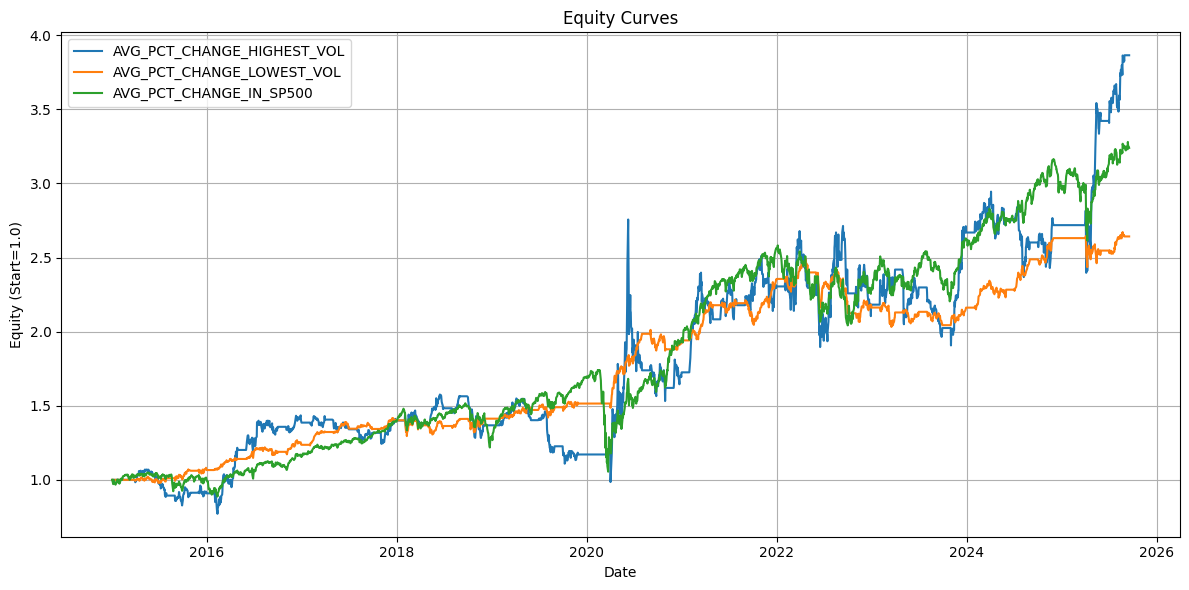

In [9]:
plt.figure(figsize=(12, 6))
for c in equity_curves.columns:
    plt.plot(equity_curves.index, equity_curves[c], label=c)
plt.title('Equity Curves')
plt.xlabel('Date')
plt.ylabel('Equity (Start=1.0)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()